## BASIN
An R package for statistical bio-image analysis under development by the University of South Dakota Biomedical Engineering team.

### Upload Data
Upload or move your dataset to the current working directory. Note that your dataset directory must have the following structure, although your image file names can be anything:

dataset/ \
|- images/ \
&nbsp;&nbsp;&nbsp;&nbsp;|- img1.jpg \
&nbsp;&nbsp;&nbsp;&nbsp;|- img2.png \
&nbsp;&nbsp;&nbsp;&nbsp;|- etc... \
|- analysisTable.csv

In [19]:
# unzip your image folder if necessary
unzip("CD133 Biomarker.zip")

In [20]:
# type in your dataset folder name
# you can find this under the /kaggle/working folder on the right panel of your Kaggle notebook session
# OR if you're using a dataset uploaded from your own computer, type in that name instead
dataset_dir <- readline(prompt = "Enter the name of your dataset folder: ")

Enter the name of your dataset folder: CD133 Biomarker


### Load Packages and Visualize Data

In [23]:
# Install missing packages - REQUIRES INTERNET CONNECTION
# this block only needs to be ran once per session
install.packages("autothresholdr")
install.packages("plyr")
install.packages("ggplot2")
install.packages("ggpubr")
install.packages("purrr")
install.packages("stringi")
install.packages("BiocManager")
BiocManager::install("EBImage", update = TRUE, ask = FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘EBImage’ is not available for this version of R

A version

In [ ]:
# Load required packages
library(autothresholdr)
library(plyr)
library(ggplot2)
library(ggpubr)
library(purrr)
library(stringi)
library(EBImage)

# Load and visualize data
img_dir <- file.path(dataset_dir, "images")
filenames <- list.files(img_dir)
imgs <- lapply(filenames, function(x){
    path <- file.path(img_dir,x)
    readImage(path)
})
# make sure all input images are RGB
imgs <- lapply(imgs, function(x){
  if(numberOfFrames(x) == 1){
    toRGB(x)
  } else {
    x[,,1:3]
  }
}) 
# resize and display all images
dimx <- imgs[[1]]@dim[1]
dimy <- imgs[[1]]@dim[2]
imgs.vis <- lapply(imgs, resize, w = dimx, h = dimy)
display(EBImage::combine(imgs.vis), method = "raster", all = TRUE, nx = 5)

### Apply Thresholding and Object Detection
In BASIN ML, users have multiple options for thresholding. Beyond the standard thresholding methods available in BASIN lite, we have two ML-based cell segmentation methods: Cellpose and a standard pre-trained U-Net. In order to utilize these ML methods, we require a Python environment. We have provided a Python notebook for segmenting your images, which you can use to generate your masks and re-upload them into this notebook. Please select your thresholding method below, make sure you upload your 'masks.zip' output folder, and proceed with the rest of the workflow.

In [ ]:
# select thresholding method: one of 'auto', 'cellpose', or 'unet'
thresh.auto <- readline()
if(thresh.auto != "cellpose" & thresh.auto != "unet"){
  thresh.auto <- "Otsu"
} else {
  unzip("masks.zip")
}

In [ ]:
# extract all RGB frames
imgs.r <- lapply(imgs, function(x) getFrame(x, 1))
imgs.g <- lapply(imgs, function(x) getFrame(x, 2))
imgs.b <- lapply(imgs, function(x) getFrame(x, 3))
names(imgs.r) <- filenames
names(imgs.g) <- filenames
names(imgs.b) <- filenames

# threshold images using EBImage's built-in Otsu method
autothreshold <- function(x) {
        y <- x*(2^16-1)
        if(!all(y == 0)){
            z <- mask(y, method = thresh.auto)
            x <- x*z
        }
        return(x)
      }

if(thresh.auto == "Otsu"){
  imgs.r.thresholded <- lapply(imgs.r, autothreshold)
  imgs.g.thresholded <- lapply(imgs.g, autothreshold)
  imgs.b.thresholded <- lapply(imgs.b, autothreshold)
}else{
  r.thresh <- list.files("/masks/red")
  g.thresh <- list.files("/masks/green")
  b.thresh <- list.files("/masks/blue")
  imgs.r.thresholded <- lapply(r.thresh, function(x){
    path <- file.path("masks","red",x)
    readImage(path)
  })
  imgs.g.thresholded <- lapply(g.thresh, function(x){
    path <- file.path("masks","green",x)
    readImage(path)
  })
  imgs.b.thresholded <- lapply(b.thresh, function(x){
    path <- file.path("masks","blue",x)
    readImage(path)
  })
}

# generate labels for segmented objects               
imgs.r.label <- lapply(imgs.r.thresholded, EBImage::bwlabel)
imgs.g.label <- lapply(imgs.g.thresholded, EBImage::bwlabel)
imgs.b.label <- lapply(imgs.b.thresholded, EBImage::bwlabel)
names(imgs.r.label) <- filenames
names(imgs.g.label) <- filenames
names(imgs.b.label) <- filenames
                 
# color code image labels
imgs.r.clrlabel <- lapply(imgs.r.label, EBImage::colorLabels)
imgs.g.clrlabel <- lapply(imgs.g.label, EBImage::colorLabels)
imgs.b.clrlabel <- lapply(imgs.b.label, EBImage::colorLabels)

# superimpose the object color labels on the original image
imgs.r.pntd <- mapply(function(x,tgt){
  EBImage::paintObjects(x,EBImage::channel(tgt,"asred"),col = "yellow")
}, x = imgs.r.label, tgt = imgs.r, SIMPLIFY = FALSE)
imgs.g.pntd <- mapply(function(x,tgt){
  EBImage::paintObjects(x,EBImage::channel(tgt,"asgreen"),col = "yellow")
}, x = imgs.g.label, tgt = imgs.g, SIMPLIFY = FALSE)
imgs.b.pntd <- mapply(function(x,tgt){
  EBImage::paintObjects(x,EBImage::channel(tgt,"asblue"),col = "yellow")
}, x = imgs.b.label, tgt = imgs.b, SIMPLIFY = FALSE)

### Visualize Thresholding and Object Detection Workflow

[1] "Displaying the following selected image: jayanthan_mge_sorafenib.jpg"


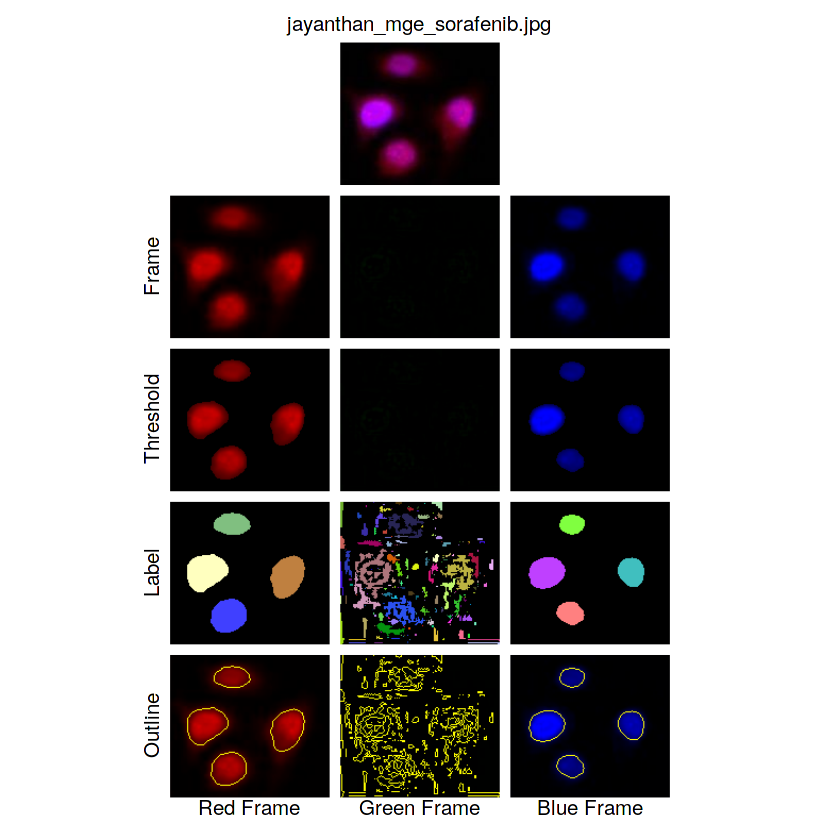

In [ ]:
# Visualize the thresholding, object detection, and composite images
c <- 4 # choose an image to display
print(paste0("Displaying the following selected image: ",filenames[c][[1]]))
selectedImg <- imgs[c][[1]]                                     
selectedImg.r <- EBImage::channel(imgs.r[c][[1]],"asred")
selectedImg.g <- EBImage::channel(imgs.g[c][[1]],"asgreen")
selectedImg.b <- EBImage::channel(imgs.b[c][[1]],"asblue")
selectedImg.r.th <- EBImage::channel(imgs.r.thresholded[c][[1]],"asred")
selectedImg.g.th <- EBImage::channel(imgs.g.thresholded[c][[1]],"asgreen")
selectedImg.b.th <- EBImage::channel(imgs.b.thresholded[c][[1]],"asblue")
selectedImg.r.clbl <- imgs.r.clrlabel[c][[1]]
selectedImg.g.clbl <- imgs.g.clrlabel[c][[1]]
selectedImg.b.clbl <- imgs.b.clrlabel[c][[1]]
selectedImg.r.pntd <- imgs.r.pntd[c][[1]]
selectedImg.g.pntd <- imgs.g.pntd[c][[1]]
selectedImg.b.pntd <- imgs.b.pntd[c][[1]]
# Blank canvas for formatting
blankSpot <- Image(matrix("white",dim(selectedImg)[1],dim(selectedImg)[2]))
# Formatted Image display
EBImage::display(                                                           
  EBImage::combine(
    blankSpot, selectedImg, blankSpot,
    selectedImg.r, selectedImg.g, selectedImg.b,
    selectedImg.r.th, selectedImg.g.th, selectedImg.b.th,
    selectedImg.r.clbl, selectedImg.g.clbl, selectedImg.b.clbl,
    selectedImg.r.pntd, selectedImg.g.pntd, selectedImg.b.pntd
  ), nx = 3, spacing = 10, margin = 40, method = "raster", all = TRUE
)

# Vertical Labels
text(x = (10 + dim(selectedImg)[1] + dim(selectedImg)[1]/2), y = -10,       
     label = filenames[c][[1]], adj = c(0.5, 0), col="black", cex=1)
text(x = -10, y = (10 + dim(selectedImg)[2] + dim(selectedImg)[2]/2), 
     label = "Frame", adj = c(0.5, 0), col = "black", cex = 1, srt = 90)
text(x = -10, y = (20 + 2*dim(selectedImg)[2] + dim(selectedImg)[2]/2), 
     label = "Threshold", adj = c(0.5, 0), col = "black", cex = 1, srt = 90)
text(x = -10, y = (30 + 3*dim(selectedImg)[2] + dim(selectedImg)[2]/2), 
     label = "Label", adj = c(0.5, 0), col = "black", cex = 1, srt = 90)
text(x = -10, y = (40 + 4*dim(selectedImg)[2] + dim(selectedImg)[2]/2), 
     label = "Outline", adj = c(0.5, 0), col = "black", cex = 1, srt = 90)

# Horizontal Labels
text(x = selectedImg@dim[1]/2, y = (50 + 5*selectedImg@dim[2]),             
     label = "Red Frame", col = "black", cex = 1)
text(x = 10 + 1.5*selectedImg@dim[1], y = (50 + 5*selectedImg@dim[2]),
     label = "Green Frame", col = "black", cex = 1)
text(x = 20 + 2.5*selectedImg@dim[1], y = (50 + 5*selectedImg@dim[2]),
     label = "Blue Frame", col = "black", cex = 1)

### Load Analysis Table
This table will be utilized in a statistical analysis of image features. Required columns are "filename", "stain", "experiment" (whole number), "biocondition" (one of "control" or "test"), "alternative" (one of ">","<", or "not=", alternative hypothesis for statistical testing), and "color frame" (one of "red", "green", or "blue", specifying the RGB frame which corresponds to the given stain).

In [ ]:
# user dataset analysis table
analysisTable <- read.csv(file.path(dataset_dir,"analysisTable.csv"))
# make sure all image rows are aligned properly with the input image order
ordering <- match(filenames, analysisTable$filename)
analysisTable <- analysisTable[ordering,]
# fetch color-coding for stains
redStain <- rep('Red Frame', length(analysisTable$filename))
greenStain <- rep('Green Frame', length(analysisTable$filename))
blueStain <- rep('Blue Frame', length(analysisTable$filename))
if(!is.null(analysisTable$'color.frame')){
    red <- analysisTable$'color.frame' == 'red' & analysisTable$'stain' != ""
    green <- analysisTable$'color.frame' == 'green' & analysisTable$'stain' != ""
    blue <- analysisTable$'color.frame' == 'blue' & analysisTable$'stain' != ""
    redStain[red] <- as.vector(analysisTable$'stain'[red])
    greenStain[green] <- as.vector(analysisTable$'stain'[green])
    blueStain[blue] <- as.vector(analysisTable$'stain'[blue])
}
# color-coding for graphs
reds <- unique(redStain)
greens <- unique(greenStain)
blues <- unique(blueStain)
colorCode <- c(rep("salmon",length(reds)), rep("green3",length(greens)),rep("cornflower blue",length(blues)))
names(colorCode) <- c(reds, greens, blues)
analysisTable[1:6,c("filename","stain","experiment","biocondition","alternative","color.frame")]

,filename,stain,experiment,biocondition,alternative,color.frame
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
1,jayanthan_mge_irinotecan.jpg,TagRFP,1,control,not=,red
2,jayanthan_mge_irinotecan2.jpg,TagRFP,1,test,not=,red
3,jayanthan_mge_nt.jpg,BFP,2,control,not=,blue
4,jayanthan_mge_sorafenib.jpg,BFP,2,test,not=,blue
5,messerli_f3_astrocyte_vatalanib_mge.jpg,GFP,3,control,not=,green
6,messerli_f3_astrocyte_vatalanib_mge2.jpg,GFP,3,test,not=,green


### Save uploading/preprocessing information
In order to improve reproducibility and traceback, BASIN saves results at three different stages of the workflow

In [ ]:
# set your home directory (where the BASIN output folder will be)
home_dir <- getwd()

In [ ]:
sessionID <- format.POSIXct(Sys.time(), format = "%m-%d-%Y-%H%M%S")

outputName <- paste0("basinOutput",sessionID)
dir.create(outputName)
setwd(outputName)
dir.create("Upload")
dir.create(file.path("Upload","Images"))
# save a compressed copy of all input images to the output folder
for(i in seq_along(imgs)){
    writeImage(imgs[[i]], files = file.path("Upload","Images",filenames[i]), type = "jpeg", quality = 70)
}
# copy stat analysis data to output folder
write.csv(analysisTable, file.path("Upload","analysisTable.csv"))
# create Log file for this session
file.create(file.path("Upload","Log.txt"))                                             
log <- file("Upload/Log.txt", open = "a+")
analysisInfo <-  paste0(
"data file location: ", file.path(outputName,"Upload"))
writeLines("UPLOAD", con = log)
writeLines(filenames, con = log, sep = ",")
writeLines(analysisInfo, con = log, sep = "")
writeLines("\n", con = log)
close(log)

setwd(home_dir)

[1] TRUE

### Feature-Extraction Function

In [ ]:
# Function to safely extract feature-data from images
featureExtract <- function(labeled, reference, stain){                      
      labeledNames <- filenames                                           
      fileCount <- length(labeled)
      counter <- 0
        mapply(function(l, r, s) {
          tryCatch({
            counter <<- counter + 1
            basicFeatures <- computeFeatures.basic(x = l, ref = r)
            momentFeatures <- computeFeatures.moment(x = l, ref = r)
            shapeFeatures <- computeFeatures.shape(x = l)
            features <- data.frame(
              experiment = analysisTable$experiment[counter],
              biocondition = analysisTable$biocondition[counter],
              stain = s,
              basicFeatures,
              momentFeatures,
              shapeFeatures, stringsAsFactors = FALSE)
            return(features)
          },
          # reapply image morphology functions to problem image
          error = function(cond){                                               
            imgThresh <- autothreshold(r)
            imgLabel <- bwlabel(imgThresh)
            basicFeatures <- computeFeatures.basic(imgLabel, ref = r)
            # check for null features (blank images/frames)
            if(is.null(basicFeatures)){
              basicFeatures <- data.frame(b.mean = 0, b.sd = 0, b.mad = 0, b.q001=0, b.q005=0, b.q05=0, b.q095=0, b.q099=0)
              momentFeatures <- data.frame(m.cx=0, m.cy=0, m.majoraxis=0, m.eccentricity=0, m.theta=0)
              shapeFeatures <- data.frame(s.area=0, s.perimeter=0, s.radius.mean=0, s.radius.sd=0, s.radius.min=0, s.radius.max=0)
            } else {
              momentFeatures <- computeFeatures.moment(imgLabel, ref = r)
              shapeFeatures <- computeFeatures.shape(imgLabel)
            }
            features <- data.frame(
              experiment = analysisTable$experiment[counter],
              biocondition = analysisTable$biocondition[counter],
              stain = s,
              basicFeatures,
              momentFeatures,
              shapeFeatures, stringsAsFactors = FALSE)
            return(features)
          })
        },
        l = labeled, r = reference, s = stain, SIMPLIFY = FALSE)
    }

### Compute Object Features

In [ ]:
# Evaluate Features for each image's frames
features.r <- featureExtract(
  imgs.r.label, reference = imgs.r, 
  #stain = "Red")
  stain = redStain)
features.g <- featureExtract(
  imgs.g.label, reference = imgs.g, 
  #stain = "Green")
  stain = greenStain)
features.b <- featureExtract(
  imgs.b.label, reference = imgs.b, 
  #stain = "Blue")
  stain = blueStain)

# Convert list of feature data into data frame
featuresDF.r <- ldply(features.r, .id = "filename")             
featuresDF.g <- ldply(features.g, .id = "filename")
featuresDF.b <- ldply(features.b, .id = "filename")

featuresDF.r$biocondition <- paste0(featuresDF.r$biocondition,".r")
featuresDF.g$biocondition <- paste0(featuresDF.g$biocondition,".g")
featuresDF.b$biocondition <- paste0(featuresDF.b$biocondition,".b")

featuresDF.all <- rbind(featuresDF.r,featuresDF.g,featuresDF.b)
maxObjectArea <- max(featuresDF.all$s.area)

# visualize sub-sample of results
head(featuresDF.all)

,filename,experiment,biocondition,stain,b.mean,b.sd,b.mad,b.q001,b.q005,b.q05,⋯,m.cy,m.majoraxis,m.eccentricity,m.theta,s.area,s.perimeter,s.radius.mean,s.radius.sd,s.radius.min,s.radius.max
,<fct>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,jayanthan_mge_irinotecan.jpg,1,control.r,TagRFP,0.2487290,0.06542441,0.08139765,0.1381961,0.1450980,0.2588235,⋯,40.98483,24.35677,0.5835349,1.3106571,425,67,11.18426,0.9516526,9.573321,12.90924
2,jayanthan_mge_irinotecan.jpg,1,control.r,TagRFP,0.2681978,0.07975843,0.08721176,0.1411765,0.1529412,0.2588235,⋯,50.25603,39.12627,0.8162648,-0.2899900,753,93,15.19360,2.7932030,10.035306,19.55549
3,jayanthan_mge_irinotecan.jpg,1,control.r,TagRFP,0.2639477,0.07156981,0.08721176,0.1372549,0.1490196,0.2666667,⋯,83.58465,30.35177,0.5596082,-0.5516434,675,83,14.22047,1.0363564,12.174167,15.80966
4,jayanthan_mge_irinotecan2.jpg,1,test.r,TagRFP,0.2487290,0.06542441,0.08139765,0.1381961,0.1450980,0.2588235,⋯,40.98483,24.35677,0.5835349,1.3106571,425,67,11.18426,0.9516526,9.573321,12.90924
5,jayanthan_mge_irinotecan2.jpg,1,test.r,TagRFP,0.2681978,0.07975843,0.08721176,0.1411765,0.1529412,0.2588235,⋯,50.25603,39.12627,0.8162648,-0.2899900,753,93,15.19360,2.7932030,10.035306,19.55549
6,jayanthan_mge_irinotecan2.jpg,1,test.r,TagRFP,0.2639477,0.07156981,0.08721176,0.1372549,0.1490196,0.2666667,⋯,83.58465,30.35177,0.5596082,-0.5516434,675,83,14.22047,1.0363564,12.174167,15.80966


### Compute Object Counts for the Feature Detection results

In [ ]:
# OPTIONAL: Threshold your features based on object area
#print(paste("Range of areas (in pixels) for detected objects:",0,"-",maxObjectArea))
#minArea <- readline("Select Minimum Object Area Threshold:")
#maxArea <- readline("Select Maximum Object Area Threshold:")
#features.r <- lapply(features.r, function(x){
#    x_new <- subset.data.frame(x, s.area > minArea & s.area < maxArea)
#    if(nrow(x_new) == 0){
#        x_new <- x_new[1,]
#        x_new[1,4:ncol(x_new)] <- 0
#      }
#    return(x_new)
#})
#features.g <- lapply(features.g, function(x){
#  x_new <- subset.data.frame(x, s.area > minArea & s.area < maxArea)
#  if(nrow(x_new) == 0){
#    x_new <- x_new[1,]
#    x_new[1,4:ncol(x_new)] <- 0
#  }
#  return(x_new)
#})
#features.b <- lapply(features.b, function(x){
#  x_new <- subset.data.frame(x, s.area > minArea & s.area < maxArea)
#  if(nrow(x_new) == 0){
#    x_new <- x_new[1,]
#    x_new[1,4:ncol(x_new)] <- 0
#  }
#  return(x_new)
#})

#featuresDF.r <- ldply(req(features.r), .id = "filename")             # Convert list of feature data into data frame
#featuresDF.g <- ldply(req(features.g), .id = "filename")
#featuresDF.b <- ldply(req(features.b), .id = "filename")

#featuresDF.r$biocondition <- paste0(featuresDF.r$biocondition,".r")
#featuresDF.g$biocondition <- paste0(featuresDF.g$biocondition,".g")
#featuresDF.b$biocondition <- paste0(featuresDF.b$biocondition,".b")

#featuresDF.all <- rbind(featuresDF.r,featuresDF.g,featuresDF.b)

In [ ]:
# Object count determined using number of rows
count.r <- lapply(features.r, function(x){
      counts <- nrow(x)
      if(counts == 1 && x$b.mean == 0){
        counts <- 0
      }
      return(counts)
    })                                  
count.g <- lapply(features.g, function(x){
      counts <- nrow(x)
      if(counts == 1 && x$b.mean == 0){
        counts <- 0
      }
      return(counts)
})
count.b <- lapply(features.b, function(x){
      counts <- nrow(x)
      if(counts == 1 && x$b.mean == 0){
        counts <- 0
      }
      return(counts)
})
# Converts list into data frame for raw Data table
count.r <- ldply(count.r, data.frame, .id = "biocondition")                 # Converts list into data frame for Raw Data table
count.g <- ldply(count.g, data.frame, .id = "biocondition")
count.b <- ldply(count.b, data.frame, .id = "biocondition")

### Format Image Data for Plotting

In [ ]:
# Sum Intensity and Object Count Data
metadata.r <- data.frame(                                                   
      row.names = NULL,
      filename = filenames,
      condition = analysisTable$biocondition,
      stain = redStain, #"Red",
      sumImgIntensity = vapply(
        imgs, function(x) {sum(imageData(x)[,,1])}, numeric(1)),
      objCount = count.r$X..i..,
      sumObjIntensity = vapply(
        imgs.r.thresholded, function(x) {sum(imageData(x))},numeric(1)),
      meanObjIntensity = vapply(
        features.r, function(x){ mean(x$b.mean) }, numeric(1)),
      sumObjArea = vapply(
        features.r, function(x){ sum(x$s.area) }, numeric(1)),
      meanObjArea = vapply(
        features.r, function(x){ mean(x$s.area) }, numeric(1)),
      biocondition = count.r$biocondition,
      experiment = analysisTable$experiment,
      stringsAsFactors = FALSE
    )
    
metadata.g <- data.frame(
    row.names = NULL,
    filename = filenames,
    condition = analysisTable$biocondition,
    stain = greenStain, #"Green",
    sumImgIntensity = vapply(
    imgs, function(x) {sum(imageData(x)[,,2])}, numeric(1)),
    objCount = count.g$X..i..,
    sumObjIntensity = vapply(
    imgs.g.thresholded, function(x) {sum(imageData(x))},numeric(1)),
    meanObjIntensity = vapply(
    features.g, function(x){ mean(x$b.mean) }, numeric(1)),
    sumObjArea = vapply(
    features.g, function(x){ sum(x$s.area) }, numeric(1)),
    meanObjArea = vapply(
    features.g, function(x){ mean(x$s.area) }, numeric(1)),
    biocondition = count.g$biocondition,
    experiment = analysisTable$experiment,
    stringsAsFactors = FALSE
)
    
metadata.b <- data.frame(
    row.names = NULL,
    filename = filenames,
    condition = analysisTable$biocondition,
    stain = blueStain, #"Blue",
    sumImgIntensity = vapply(
    imgs, function(x) {sum(imageData(x)[,,3])}, numeric(1)),
    objCount = count.b$X..i..,
    sumObjIntensity = vapply(
    imgs.b.thresholded, function(x) {sum(imageData(x))},numeric(1)),
    meanObjIntensity = vapply(
    features.b, function(x){ mean(x$b.mean) }, numeric(1)),
    sumObjArea = vapply(
    features.b, function(x){ sum(x$s.area) }, numeric(1)),
    meanObjArea = vapply(
    features.b, function(x){ mean(x$s.area) }, numeric(1)),
    biocondition = count.b$biocondition,
    experiment = analysisTable$experiment,
    stringsAsFactors = FALSE
)
    
# function to format metadata table
format.metadata <- function(red,green,blue){                                
  output <- NULL
  for(i in 1:nrow(red)){
    output <- rbind(output,red[i,],green[i,],blue[i,])
  }
  return(output)
}

barplotData <- format.metadata(metadata.r,metadata.g,metadata.b)
head(barplotData)

,filename,condition,stain,sumImgIntensity,objCount,sumObjIntensity,meanObjIntensity,sumObjArea,meanObjArea,biocondition,experiment
,<chr>,<fct>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,jayanthan_mge_irinotecan.jpg,control,TagRFP,693.29412,3,485.8275,0.26029149,1853,617.66667,jayanthan_mge_irinotecan.jpg,1
2,jayanthan_mge_irinotecan.jpg,control,Green Frame,83.99216,71,20.4902,0.02102297,774,10.90141,jayanthan_mge_irinotecan.jpg,1
3,jayanthan_mge_irinotecan.jpg,control,Blue Frame,1172.33725,3,943.1216,0.49514931,1909,636.33333,jayanthan_mge_irinotecan.jpg,1
21,jayanthan_mge_irinotecan2.jpg,test,TagRFP,693.29412,3,485.8275,0.26029149,1853,617.66667,jayanthan_mge_irinotecan2.jpg,1
22,jayanthan_mge_irinotecan2.jpg,test,Green Frame,83.99216,71,20.4902,0.02102297,774,10.90141,jayanthan_mge_irinotecan2.jpg,1
23,jayanthan_mge_irinotecan2.jpg,test,Blue Frame,1172.33725,3,943.1216,0.49514931,1909,636.33333,jayanthan_mge_irinotecan2.jpg,1


### Net Intensity and Object Count differences across biocondition

In [ ]:
# function that computes the net intensity difference and object count difference across experimental groups
# assumes that the input data is one of the metadata tables used to construct the image metadata table (values$barplotData)
intensityAndCountDifference <- function(data){
  data <- data[order(data$experiment),]
  control <- data[data$condition == "control",]
  test <- data[data$condition == "test",]
  netIntensityDiff <- vaggregate(control$sumImgIntensity, control$experiment, mean) - vaggregate(test$sumImgIntensity, test$experiment, mean)
  objCountDiff <- vaggregate(control$objCount, control$experiment, mean) - vaggregate(test$objCount, test$experiment, mean)
  stainInfo <- vapply(split(data$stain, data$experiment), function(x){x[[1]]}, character(1))
  outTable <- data.frame(unique(data$experiment),stainInfo,netIntensityDiff,objCountDiff)
  names(outTable) <- c("experiment", "stain", "Net Image Intensity Difference", "Object Count Difference")
  return(outTable)
}

# format the differences table
diff.r <- intensityAndCountDifference(metadata.r)
diff.g <- intensityAndCountDifference(metadata.g)
diff.b <- intensityAndCountDifference(metadata.b)
differenceData <- rbind(diff.r, diff.g, diff.b)
differenceData <- differenceData[order(differenceData$experiment),]
head(differenceData)

,experiment,stain,Net Image Intensity Difference,Object Count Difference
,<int>,<fct>,<dbl>,<dbl>
1,1,TagRFP,0.00000,0
11,1,Green Frame,0.00000,0
12,1,Blue Frame,0.00000,0
2,2,Red Frame,-366.74510,-1
21,2,Green Frame,2.65098,-176
22,2,BFP,-13.31373,-1


### Visualize Summary Data

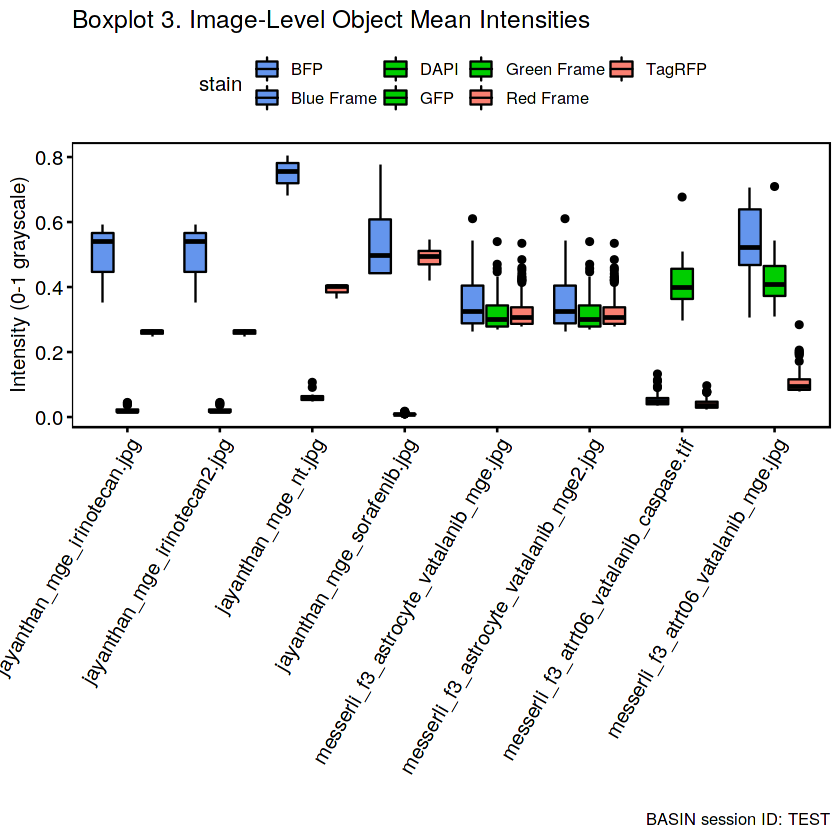

In [ ]:
# Image-Level Intensity Plot
ggboxplot(
  data = featuresDF.all,
  x = "filename",
  y = "b.mean",
  combine = TRUE,
  fill = "stain",
  palette = colorCode,
  title = "Boxplot 3. Image-Level Object Mean Intensities",
  xlab = "",
  ylab = "Intensity (0-1 grayscale)",
  caption = paste0("BASIN session ID: ", "TEST")
) + 
rotate_x_text(angle = 60)

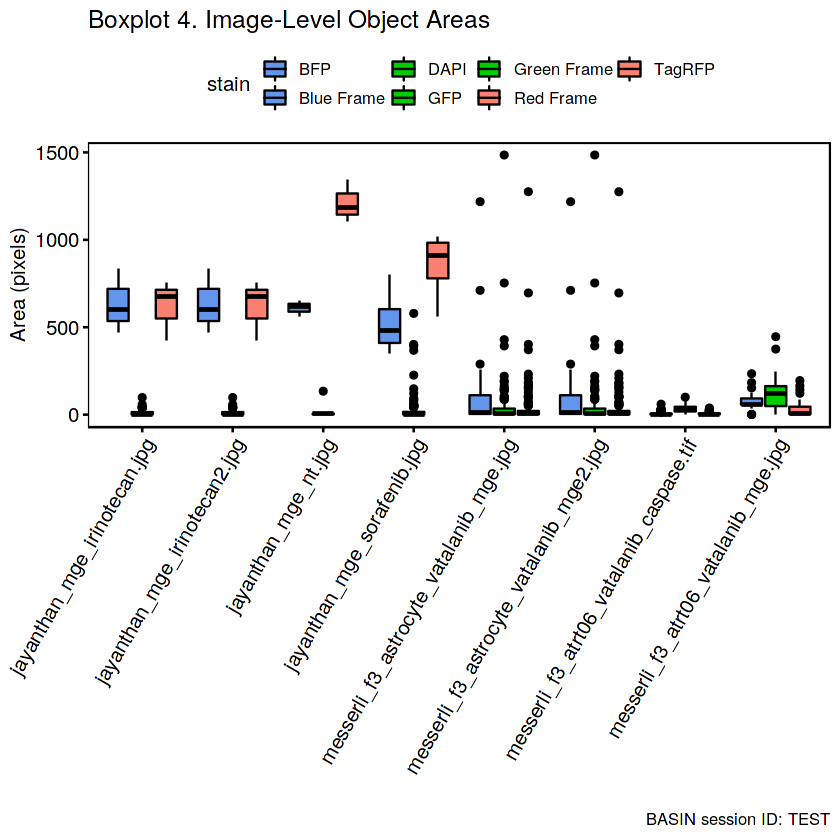

In [ ]:
# Image-Level Area Plot  
ggboxplot(
  data = featuresDF.all,
  x = "filename",
  y = "s.area",
  combine = TRUE,
  fill = "stain",
  palette = colorCode,
  title = "Boxplot 4. Image-Level Object Areas",
  xlab = "",
  ylab = "Area (pixels)",
  caption = paste0("BASIN session ID: ", "TEST")
) +
  rotate_x_text(angle = 60)

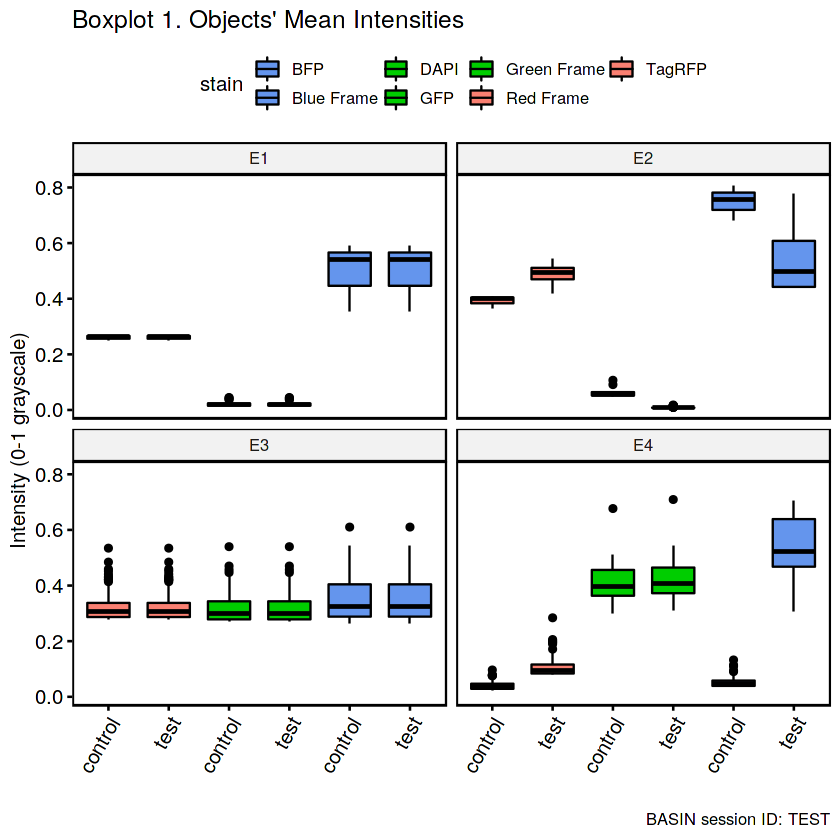

In [ ]:
# Boxplot for the Mean Instensities grouped by Condition (Control vs. Test)
ggboxplot(
  data = featuresDF.all,
  x = "biocondition",
  y = "b.mean",
  fill = "stain",
  palette = colorCode,
  title = "Boxplot 1. Objects' Mean Intensities",
  xlab = "",
  ylab = "Intensity (0-1 grayscale)",
  panel.labs = list(experiment = paste0(
    "E", levels(as.factor(featuresDF.all$experiment)))),
  facet.by = "experiment",
  caption = paste0("BASIN session ID: ", "TEST")
) + 
  rotate_x_text(angle = 60) +
  scale_x_discrete(labels = rep(c("control", "test"), 3))

Warning message:
“Removed 142 rows containing non-finite values (stat_boxplot).”


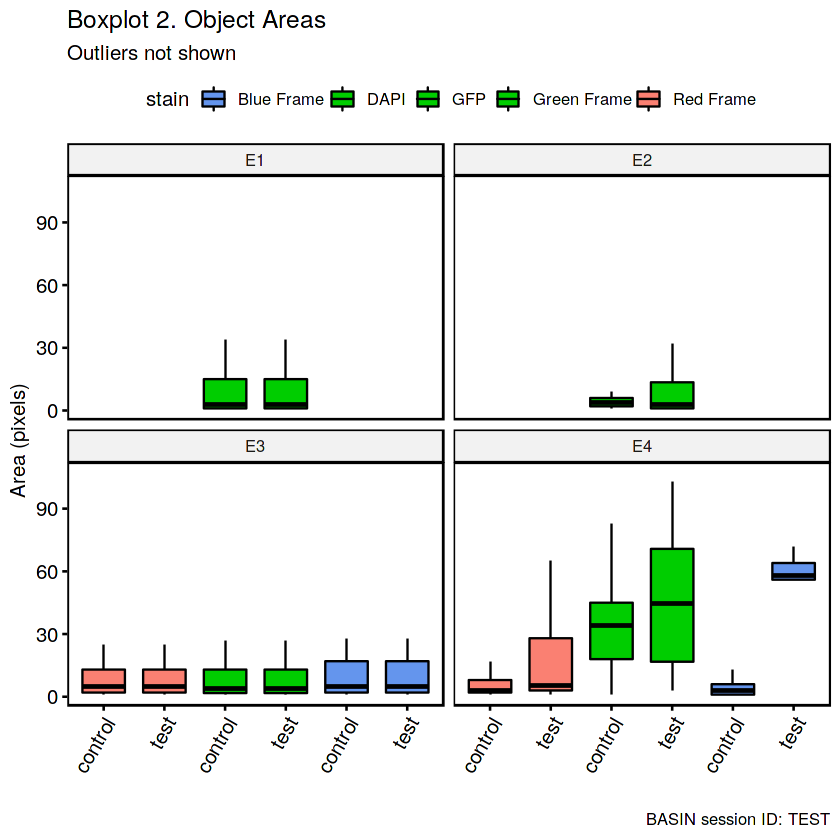

In [ ]:
# Boxplot for the Object Areas grouped by Condition (Control vs. Test)
ggboxplot(
  data = featuresDF.all,
  x = "biocondition",
  y = "s.area",
  fill = "stain",
  palette = colorCode,
  title = "Boxplot 2. Object Areas",
  subtitle = "Outliers not shown",
  xlab = "",
  ylab = "Area (pixels)",
  panel.labs = list(experiment = paste0(
    "E",levels(as.factor(featuresDF.all$experiment)))),
  facet.by = "experiment",
  caption = paste0("BASIN session ID: ", "TEST"),
  outlier.shape = NA
) + 
  rotate_x_text(angle = 60) +
  scale_x_discrete(labels = rep(c("control", "test"), 3)) +
  scale_y_continuous(
    limits = quantile(featuresDF.all$s.area, c(0.1, 0.9)))

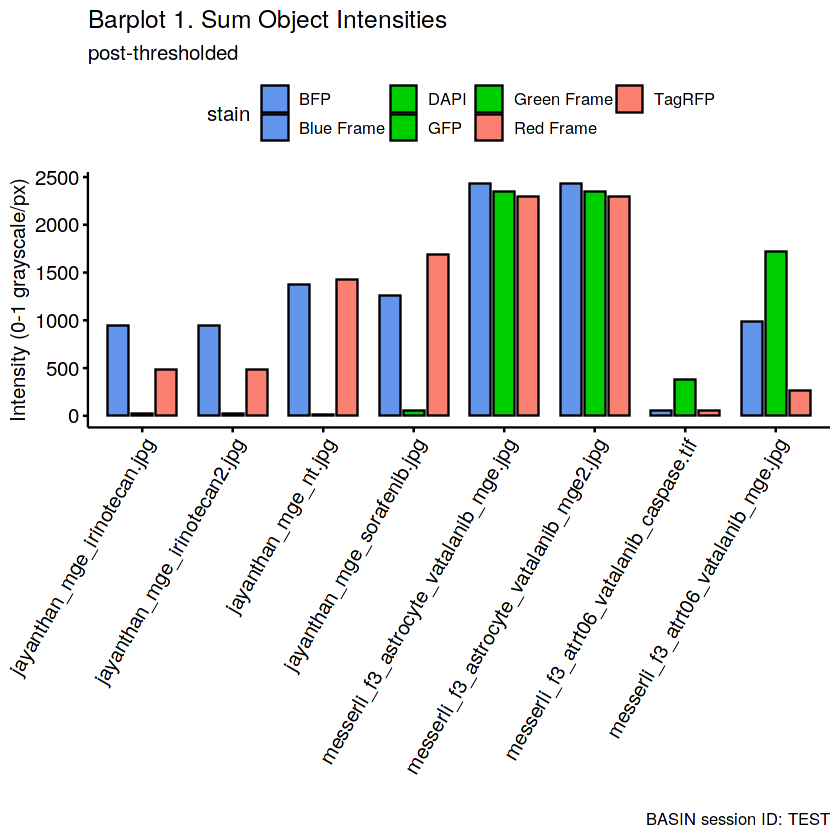

In [ ]:
# Sum Object Intensities Graph
ggbarplot(
      data = barplotData,
      x = "filename",
      y = "sumObjIntensity",
      combine = FALSE,
      merge = TRUE,
      fill = "stain",
      palette = colorCode,
      title = "Barplot 1. Sum Object Intensities",
      subtitle = "post-thresholded",
      # add = "mean_se",
      # error.plot = "pointrange",
      xlab = "",
      ylab = "Intensity (0-1 grayscale/px)",
      caption = paste0("BASIN session ID: ", "TEST")
    ) + 
    rotate_x_text(angle = 60)

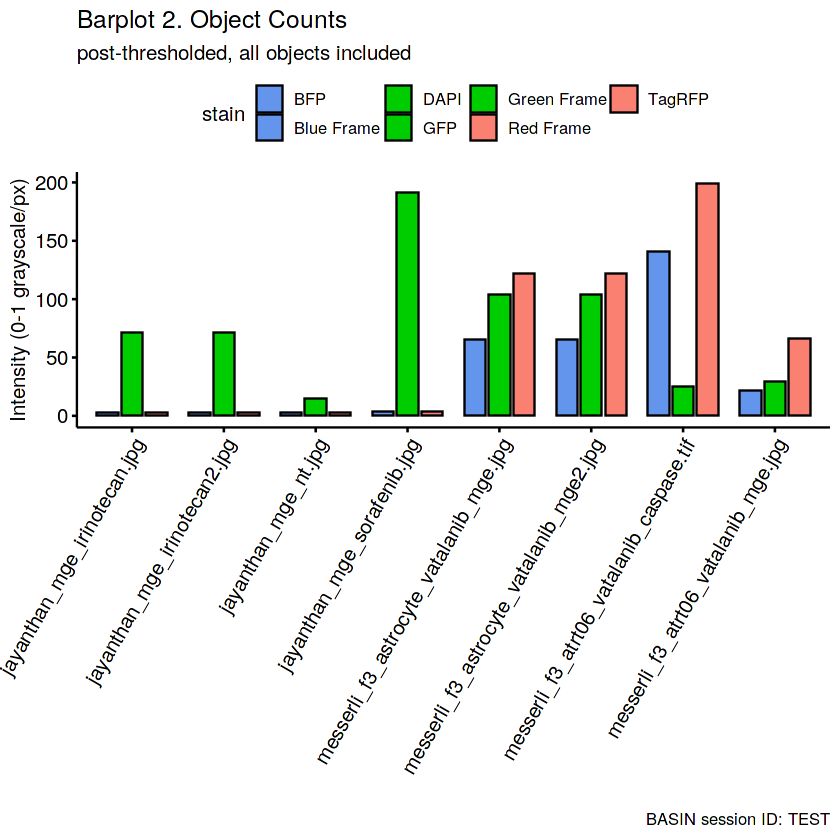

In [ ]:
# Object Counts for all Images
ggbarplot(
      data = barplotData,
      x = "filename",
      y = "objCount",
      combine = FALSE,
      merge = TRUE,
      fill = "stain",
      palette = colorCode,
      title = "Barplot 2. Object Counts",
      subtitle = "post-thresholded, all objects included",
      # add = "mean_se",
      # error.plot = "errorbar",
      xlab = "",
      ylab = "Intensity (0-1 grayscale/px)",
      caption = paste0("BASIN session ID: ", "TEST")
    ) + 
    rotate_x_text(angle = 60) 

### Analysis of Aggregate Control and Test Groups

In [ ]:
# Define some useful functions
tTestToDataFrame <- function(results, frame, altHypo){                          
  if(!is.na(results[[1]])){
    data.frame(
      "stain" = frame, "Ha" = altHypo, "t-statistic" = results$statistic,
      "df" = results$parameter, "p-value" = results$p.value, 
      "lower conf int" = results$conf.int[1], 
      "upper conf int" = results$conf.int[2], 
      "conf level" = attributes(results$conf.int)$conf.level, 
      method = results$method, check.names = FALSE)
  } else {
    data.frame(
      "stain" = frame, "Ha" = "not tested", "t-statistic" = NA, 
      "df" = NA, "p-value" = NA, 
      "lower conf int" = NA, "upper conf int" = NA, 
      "conf level" = NA, method = NA, check.names = FALSE)
  }
}

# Function to extract the chosen column from feature data
colExtract <- function(x, column){                                              
  tryCatch({
    as.vector(x[column])
  },
  error = function(cond){
    x <- data.frame(b.mean = 0, b.sd = 0, b.mad = 0, s.area = 0)
    return(x[column])
  })
}

# Translates alternative hypothesis from simple symbols in the analysis table
alternative <- function(x){
  alt <- x$alternative
  if(all(is.na(alt))){return(NA)}
  if(any(stri_cmp_eq(alt,"not="))){
    return("two.sided")
  } else if(any(stri_cmp_eq(alt,"<"))){
    return("less")
  } else if(any(stri_cmp_eq(alt,">"))){
    return("greater")
  } else {
    return(NA)
  }
}

In the following section we perform a statistical test comparing the means object intensities and areas for images in the "control" and "test" groups. Objects for images within each group are aggregated into a single dataset for direct comparison.

In [ ]:
# Subset  by experimental group
groupedExperimentTable <- split(                                     
      x = analysisTable, f = analysisTable$experiment)
    
# Compute t-test for mean intensities
meanIntensities.r <- lapply(                                                
  features.r, function(x) colExtract(x, "b.mean"))
meanIntensities.g <- lapply(
  features.g, function(x) colExtract(x, "b.mean"))
meanIntensities.b <- lapply(
  features.b, function(x) colExtract(x, "b.mean"))

meanData <- lapply(groupedExperimentTable, function(x){
  controlGroup <- x[(x$biocondition == "control"),]$filename
  testGroup <- x[(x$biocondition == "test"),]$filename
  controlGroup.r <- unlist(
    meanIntensities.r[controlGroup], use.names = FALSE)
  testGroup.r <- unlist(meanIntensities.r[testGroup], use.names = FALSE)
  controlGroup.g <- unlist(
    meanIntensities.g[controlGroup], use.names = FALSE)
  testGroup.g <- unlist(meanIntensities.g[testGroup], use.names = FALSE)
  controlGroup.b <- unlist(
    meanIntensities.b[controlGroup], use.names = FALSE)
  testGroup.b <- unlist(meanIntensities.b[testGroup], use.names = FALSE)

  altHypothesis <- alternative(x)

  # get the correct staining info
  red <- ifelse(any(x$'color.frame' == 'red' & x$'stain' != ""),
                yes = as.vector(x$'stain'[x$'color.frame' == 'red'])[1],
                no = 'Red Frame')
  green <- ifelse(any(x$'color.frame' == 'green' & x$'stain' != ""),
                yes = as.vector(x$'stain'[x$'color.frame' == 'green'])[1],
                no = 'Green Frame')
  blue <- ifelse(any(x$'color.frame' == 'blue' & x$'stain' != ""),
            yes = as.vector(x$'stain'[x$'color.frame' == 'blue'])[1],
            no = 'Blue Frame')
  safeTest <- possibly(function(group1, group2){
    t.test(group1,group2,alternative = altHypothesis)
  }, otherwise = NA)
  experiment.r.results <- safeTest(controlGroup.r, testGroup.r)
  experiment.g.results <- safeTest(controlGroup.g, testGroup.g)
  experiment.b.results <- safeTest(controlGroup.b, testGroup.b)

  # Bind results as one data frame
  result <- rbind(                                                          
    redFrame = tTestToDataFrame(
      experiment.r.results,red, altHypothesis),
    greenFrame = tTestToDataFrame(
      experiment.g.results,green, altHypothesis),
    blueFrame = tTestToDataFrame(
      experiment.b.results,blue, altHypothesis))

  # T-test data pre-processing for plotting
  data <- rbind(                                                            
    data.frame("mean" = controlGroup.r,stain =red, 
               biocondition = "control.r"),
    data.frame("mean" = testGroup.r,stain = red,
               biocondition = "test.r"),
    data.frame("mean" = controlGroup.g,stain = green, 
               biocondition = "control.g"),
    data.frame("mean" = testGroup.g,stain = green, 
               biocondition = "test.g"),
    data.frame("mean" = controlGroup.b,stain = blue, 
               biocondition = "control.b"),
    data.frame("mean" = testGroup.b,stain = blue, 
               biocondition = "test.b"))

  # Return list of t-test control group data, test group data, and t-test results
  list(data = data ,result = result)                                        
})

meanObjectData <- lapply(meanData, function(x){x$data})
objectMeanData <- ldply(meanObjectData, .id = "experiment")

meanResults <- lapply(meanData, function(x){x$result})
objectMeanResults <- ldply(meanResults, .id = "experiment")

# t-test of object area data
areas.r <- lapply(features.r, function(x) colExtract(x, "s.area"))   
areas.g <- lapply(features.g, function(x) colExtract(x, "s.area"))
areas.b <- lapply(features.b, function(x) colExtract(x, "s.area"))

areaData <- lapply(groupedExperimentTable, function(x){
  controlGroup <- x[(x$biocondition == "control"),]$filename
  testGroup <- x[(x$biocondition == "test"),]$filename
  controlGroup.r <- unlist(areas.r[controlGroup], use.names = FALSE)
  testGroup.r <- unlist(areas.r[testGroup], use.names = FALSE)
  controlGroup.g <- unlist(areas.g[controlGroup], use.names = FALSE)
  testGroup.g <- unlist(areas.g[testGroup], use.names = FALSE)
  controlGroup.b <- unlist(areas.b[controlGroup], use.names = FALSE)
  testGroup.b <- unlist(areas.b[testGroup], use.names = FALSE)

  altHypothesis <- alternative(x)
  # get the correct staining info
  red <- ifelse(any(x$'color.frame' == 'red' & x$'stain' != ""),
                yes = as.vector(x$'stain'[x$'color.frame' == 'red'])[1],
                no = 'Red Frame')
  green <- ifelse(any(x$'color.frame' == 'green' & x$'stain' != ""),
                yes = as.vector(x$'stain'[x$'color.frame' == 'green'])[1],
                no = 'Green Frame')
  blue <- ifelse(any(x$'color.frame' == 'blue' & x$'stain' != ""),
            yes = as.vector(x$'stain'[x$'color.frame' == 'blue'])[1],
            no = 'Blue Frame')
  # T-test control vs test biocondition
  safeTest <- possibly(function(group1, group2){                            
    t.test(group1,group2,alternative = altHypothesis)
  }, otherwise = NA)
  experiment.r.results <- safeTest(controlGroup.r, testGroup.r)
  experiment.g.results <- safeTest(controlGroup.g, testGroup.g)
  experiment.b.results <- safeTest(controlGroup.b, testGroup.b)

  # Bind results as one data frame
  result <- rbind(                                                          
    redFrame = tTestToDataFrame(
      experiment.r.results,red,altHypothesis),
    greenFrame = tTestToDataFrame(
      experiment.g.results,green,altHypothesis),
    blueFrame = tTestToDataFrame(
      experiment.b.results,blue,altHypothesis))

  # T-test data pre-processing for plotting
  data <- rbind(                                                            
    data.frame("area" = controlGroup.r,stain = red, 
               biocondition = "control.r"),
    data.frame("area" = testGroup.r,stain = red,
               biocondition = "test.r"),
    data.frame("area" = controlGroup.g,stain = green, 
               biocondition = "control.g"),
    data.frame("area" = testGroup.g,stain = green, 
               biocondition = "test.g"),
    data.frame("area" = controlGroup.b,stain = blue, 
               biocondition = "control.b"),
    data.frame("area" = testGroup.b,stain = blue, 
               biocondition = "test.b"))

  # Return list of t-test control group data, test group data, and t-test results
  list(data = data, result = result)                                        
})
objectAreaData = lapply(areaData, function(x){x$data})
objectAreaData = ldply(objectAreaData, .id = "experiment")

objectAreaResults = lapply(areaData, function(x){x$result})
objectAreaResults <- ldply(objectAreaResults, .id = "experiment")

In [ ]:
# Object Mean Intensity T-test Results
objectMeanResults

experiment,stain,Ha,t-statistic,df,p-value,lower conf int,upper conf int,conf level,method
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,TagRFP,two.sided,0.0000000,4.000000,1.000000e+00,-0.023205610,0.023205610,0.95,Welch Two Sample t-test
1,Green Frame,two.sided,0.0000000,140.000000,1.000000e+00,-0.002369313,0.002369313,0.95,Welch Two Sample t-test
1,Blue Frame,two.sided,0.0000000,4.000000,1.000000e+00,-0.285221292,0.285221292,0.95,Welch Two Sample t-test
2,Red Frame,two.sided,-3.3263836,4.328899,2.592515e-02,-0.174552318,-0.018296677,0.95,Welch Two Sample t-test
2,Green Frame,two.sided,12.2279663,14.021858,7.215605e-09,0.043696765,0.062282891,0.95,Welch Two Sample t-test
2,BFP,two.sided,2.2391879,4.112170,8.686932e-02,-0.044225896,0.434382811,0.95,Welch Two Sample t-test
3,Red Frame,two.sided,0.0000000,242.000000,1.000000e+00,-0.012704744,0.012704744,0.95,Welch Two Sample t-test
3,GFP,two.sided,0.0000000,206.000000,1.000000e+00,-0.014687363,0.014687363,0.95,Welch Two Sample t-test
3,Blue Frame,two.sided,0.0000000,128.000000,1.000000e+00,-0.025659937,0.025659937,0.95,Welch Two Sample t-test


In [ ]:
# Object Area Intensity T-test Results
objectAreaResults

experiment,stain,Ha,t-statistic,df,p-value,lower conf int,upper conf int,conf level,method
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,TagRFP,two.sided,0.0000000,4.000000,1.000000e+00,-388.446621,388.446621,0.95,Welch Two Sample t-test
1,Green Frame,two.sided,0.0000000,140.000000,1.000000e+00,-5.637101,5.637101,0.95,Welch Two Sample t-test
1,Blue Frame,two.sided,0.0000000,4.000000,1.000000e+00,-422.848933,422.848933,0.95,Welch Two Sample t-test
2,Red Frame,two.sided,2.8693301,4.876041,3.605630e-02,35.065452,686.267881,0.95,Welch Two Sample t-test
2,Green Frame,two.sided,-0.9523554,23.980296,3.504182e-01,-29.960046,11.041372,0.95,Welch Two Sample t-test
2,BFP,two.sided,0.7898279,3.418756,4.807724e-01,-221.578855,381.912189,0.95,Welch Two Sample t-test
3,Red Frame,two.sided,0.0000000,242.000000,1.000000e+00,-36.095421,36.095421,0.95,Welch Two Sample t-test
3,GFP,two.sided,0.0000000,206.000000,1.000000e+00,-47.399749,47.399749,0.95,Welch Two Sample t-test
3,Blue Frame,two.sided,0.0000000,128.000000,1.000000e+00,-62.575652,62.575652,0.95,Welch Two Sample t-test


### Visualize Analysis Results

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


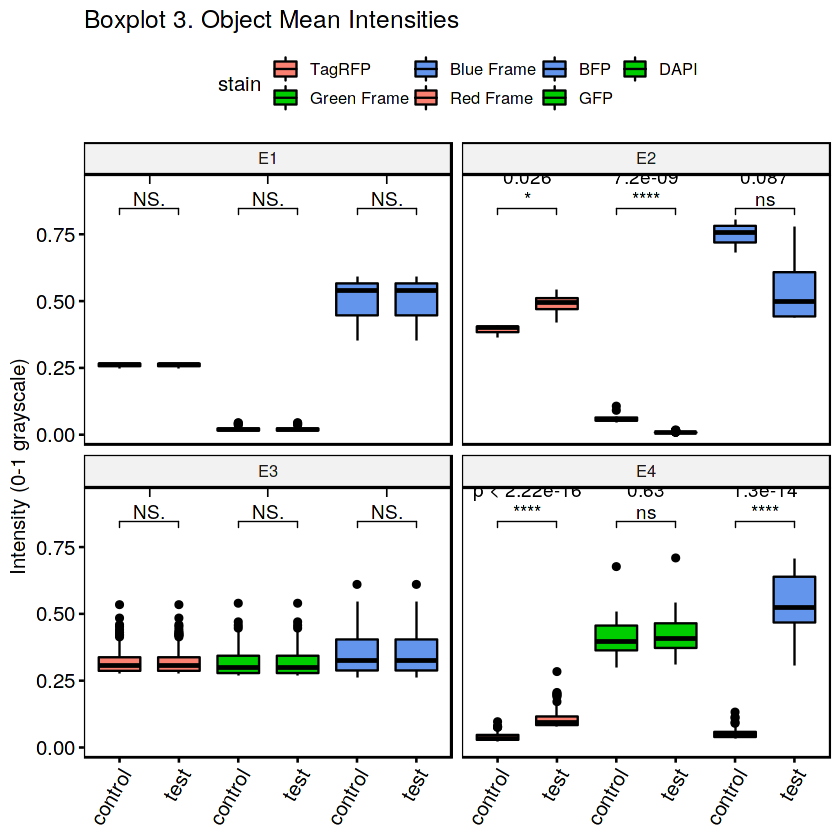

In [ ]:
# Compare the mean object intensity data between the "control" and "test" groups
ggboxplot(
      data = objectMeanData,
      x = "biocondition",
      y = "mean",
      combine = TRUE,
      merge = FALSE,
      fill = "stain",
      palette = colorCode,
      facet.by = "experiment",
      panel.labs = list(experiment = paste0(
        "E",levels(as.factor(objectMeanData$experiment)))),
      title = "Boxplot 3. Object Mean Intensities",
      xlab = FALSE,
      ylab = "Intensity (0-1 grayscale)",
      ) +
      rotate_x_text(angle = 60) +
      stat_compare_means(aes(
        label = paste0("p = ", ..p.format..)),
        method = "t.test",
        comparisons = list(
          c("control.r", "test.r"), 
          c("control.g", "test.g"), 
          c("control.b", "test.b")),
        label.y = max(featuresDF.all$b.mean)*1.15,
        bracket.size = 0) +
      stat_compare_means(
        label = "p.signif",
        method = "t.test",
        comparisons = list(
          c("control.r", "test.r"),
          c("control.g", "test.g"),
          c("control.b", "test.b")),
        label.y = max(featuresDF.all$b.mean)*1.05) +
      scale_x_discrete(labels = rep(c("control", "test"), 3))

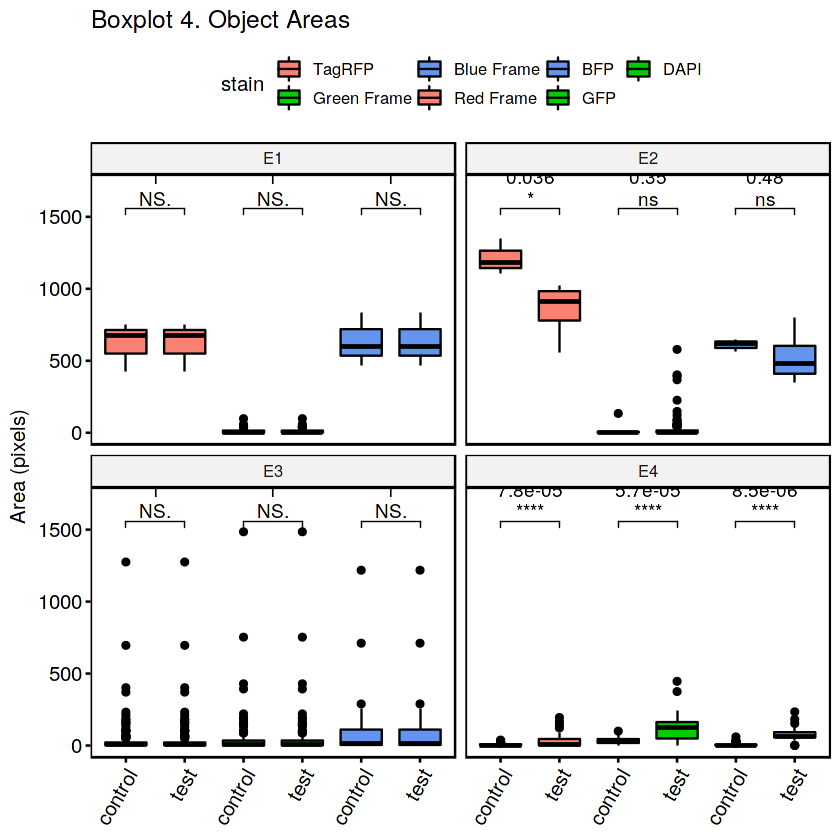

In [ ]:
# Compare the object area data between the "control" and "test" groups
ggboxplot(
      data = objectAreaData,
      x = "biocondition",
      y = "area",
      combine = TRUE,
      merge = FALSE,
      fill = "stain",
      palette = colorCode,
      facet.by = "experiment",
      panel.labs = list(experiment = paste0(
        "E",levels(as.factor(objectAreaData$experiment)))),
      title = "Boxplot 4. Object Areas",
      xlab = FALSE,
      ylab = "Area (pixels)"
      ) +
      rotate_x_text(angle = 60) +
      stat_compare_means(aes(
        label = paste0("p = ", ..p.format..)),
        method = "t.test",
        comparisons = list(
          c("control.r", "test.r"), 
          c("control.g", "test.g"), 
          c("control.b", "test.b")),
        label.y = max(featuresDF.all$s.area)*1.15,
        bracket.size = 0) +
      stat_compare_means(
        label = "p.signif", 
        method = "t.test",
        comparisons = list(
          c("control.r", "test.r"), 
          c("control.g", "test.g"), 
          c("control.b", "test.b")),
        label.y = max(featuresDF.all$s.area)*1.05) +
      scale_x_discrete(labels = rep(c("control", "test"), 3))

### Save Feature Extraction and Statistical Analysis
Save results to the output folder created previously.

In [ ]:
setwd(outputName) # temporarily change directory to basin output

# Set unique id for each run under new conditions
id <- format.POSIXct(Sys.time(), format = "%m-%d-%Y-%H%M%S")              
# Check for existing Extractor folder and subfolders
extractDir <- "Extractor"                                
rawDir <- file.path("Extractor",paste0("Thresh_Data",id))
analyzeDir <- file.path("Extractor","Analysis_Results")
maskDir <- file.path("Extractor","Image_Masks")
redMasks <- file.path(maskDir, "Red")
greenMasks <- file.path(maskDir, "Green")
blueMasks <- file.path(maskDir, "Blue")
if(!dir.exists(extractDir)){
    dir.create(extractDir)
}
if(!dir.exists(rawDir)){
    dir.create(rawDir)
}
if(!dir.exists(analyzeDir)){
    dir.create(analyzeDir)
}
if(!dir.exists(maskDir)){
    dir.create(maskDir)
    dir.create(redMasks)
    dir.create(greenMasks)
    dir.create(blueMasks)
}
# save a copy of all image masks to the output folder
masks.r <- lapply(imgs.r.thresholded, function(x){colormap(x, palette=c("white","red"))})
masks.g <- lapply(imgs.g.thresholded, function(x){colormap(x, palette=c("white","green"))})
masks.b <- lapply(imgs.b.thresholded, function(x){colormap(x, palette=c("white","blue"))})
for(i in seq_along(masks.r)){
  writeImage(masks.r[[i]], files = file.path(redMasks,filenames[i]), type = "jpeg", quality = 80)
  writeImage(masks.g[[i]], files = file.path(greenMasks,filenames[i]), type = "jpeg", quality = 80)
  writeImage(masks.b[[i]], files = file.path(blueMasks, filenames[i]), type = "jpeg", quality = 80)
}

# Copy all raw data into Thresh_Data subfolder
write.csv(ldply(features.r, .id = "filename"),                
        file = file.path(rawDir,"redFrameImageData.csv"))
write.csv(ldply(features.g, .id = "filename"), 
        file = file.path(rawDir,"greenFrameImageData.csv"))
write.csv(ldply(features.b, .id = "filename"), 
        file = file.path(rawDir,"blueFrameImageData.csv"))
write.csv(barplotData, 
        file = file.path(rawDir,"imageMetadata.csv"))
# Copy all analysis data into Analysis_Results subfolder
write.csv(objectMeanResults,                                  
        file = file.path(analyzeDir,"meanDataTtest.csv"))
write.csv(objectAreaResults, 
        file = file.path(analyzeDir,"objectAreaTtest.csv"))
write.csv(differenceData,
        file = file.path(analyzeDir,"intensityAndCountDifferences.csv"))


# Create log file with Extractor info
file.create(file.path("Extractor","Log.txt"))                             
log <- file(file.path("Extractor","Log.txt"), open = "a+")
# Format extraction parameters and extraction ID
extractInfo <- paste(                                                     
    "Extraction",id,"autothreshold method:",thresh.auto)
writeLines(extractInfo, con = log)
close(log)

setwd(home_dir)

[1] TRUE

In [ ]:
# download BASIN output by copying the path of the output directory into the promp below
basin_output_path <- readline(prompt = "Enter path to BASIN output folder to zip: ")
zip(zipfile = "basinOutput.zip", files = basin_output_path)

Enter path to BASIN output folder to zip:  ./basinOutput05-14-2021-041435
